In [1]:
import keras

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#path = "data/work_data/"
#path = "data/work_data/sample/"
path = "data/"#base_data/"
full_set_mode = "base" in path
model_path = "model/"
batch_size=24

In [3]:
import utils
from utils import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model
from keras.preprocessing import image
import os
from glob import glob
import numpy as np
import annotationHandler
import bboxgenerator

In [4]:
#This is a workaround for now to get bounding-boxes from the filename-structure of the keras-impl.
#we have to reassign the batches afterwards with boundingboxes provided.
train_path = path + 'train'
valid_path = path + 'valid'
size=(224,224)
batches = get_batches(train_path, batch_size=batch_size, shuffle=False, target_size=size)
train_bboxes = annotationHandler.create_bbx("data/annotations", size, batches.filenames, train_path)
if not full_set_mode:
    val_batches = get_batches(valid_path, batch_size=batch_size, shuffle=False, target_size=size)
    val_bboxes = annotationHandler.create_bbx("data/annotations", size, val_batches.filenames, valid_path)

Found 3062 images belonging to 8 classes.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.
Found 715 images belonging to 8 classes.
Annotations for 3297 images found.
Creating blank bounding boxes for the rest.


In [5]:
size=(224,224)
batches = bboxgenerator.DirectoryIterator(directory=train_path, batch_size=batch_size, target_size=size, shuffle=True, mappable_extras=[train_bboxes])
if not full_set_mode:
    val_batches = bboxgenerator.DirectoryIterator(valid_path, batch_size=batch_size, target_size=size, shuffle=False, mappable_extras=[val_bboxes])

Found 3062 images belonging to 8 classes.
Found 715 images belonging to 8 classes.


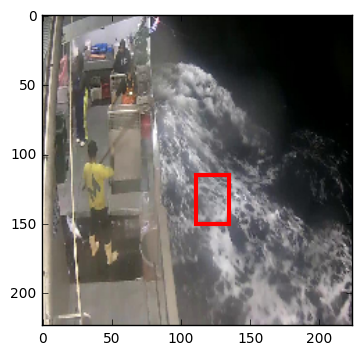

In [6]:
test = next(batches)
utils.show_bb(test, 3)

In [7]:
BASEMODELS = []

In [8]:
from keras.applications import ResNet50
resnet = ResNet50(include_top=False,input_shape=(3,224,224))
BASEMODELS.append(resnet)

In [43]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size,include_top=False)
#base_model = vgg.model
BASEMODELS.append(vgg.model)
#model.summary()

/usr/local/lib64/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


vgg16_bn_conv.h5


In [10]:
def add_single_custom_layer(base_model):
    for layer in base_model.layers:
        layer.trainable=False
    
    x = base_model.output
    x = BatchNormalization(axis=1)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x)
    newmodel = Model(input=base_model.input, output=[x_bb, x_class])
    return newmodel

def add_advanced_custom_layer(base_model): 
    for layer in base_model.layers:
        layer.trainable=False
    
    p = 0.2
    x = base_model.output
    #x = MaxPooling2D()(x)
    x = BatchNormalization(axis=1)(x)
    x = Dropout(p/4)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x)
    newmodel = Model(input=base_model.input, output=[x_bb, x_class])
    return newmodel

TOP_LAYERS = [add_advanced_custom_layer, add_single_custom_layer]

In [11]:
MODELS = [lay(base) for base in BASEMODELS for lay in TOP_LAYERS]
MODELNAMES = ['m1','m2','m3','m4']

In [ ]:
def train(model,modelname, epochs, full_run):
    
    print('running ' + modelname)
    model.compile(Adam(lr=0.001), 
              loss=['mse', 'categorical_crossentropy'], 
              metrics=['accuracy'],
              loss_weights=[.001, 1.])
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                  patience=2, min_lr=0.00001)
    
    ckpt = keras.callbacks.ModelCheckpoint( 'model/' + modelname + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', 
                                           verbose=0, save_best_only=False, save_weights_only=False, 
                                           mode='auto', period=1)

    
    if not full_run:
        model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=epochs, 
                            validation_data=val_batches, nb_val_samples=val_batches.nb_sample,
                           callbacks = [reduce_lr,ckpt])
    else:
        model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=epochs,
                           callbacks = [reduce_lr])
        
    del model

In [ ]:
for model,modelname in zip(MODELS,MODELNAMES):
    train(model,modelname, 10, full_run=full_set_mode)

running m1
Epoch 1/10
3062/3062 [==============================] - 70s - loss: 6.0572 - bb_loss: 4963.7930 - class_loss: 1.0934 - bb_acc: 0.3269 - class_acc: 0.6865 - val_loss: 5.0766 - val_bb_loss: 4561.6347 - val_class_loss: 0.5149 - val_bb_acc: 0.4503 - val_class_acc: 0.8420
Epoch 2/10
3062/3062 [==============================] - 69s - loss: 4.5855 - bb_loss: 4207.2731 - class_loss: 0.3782 - bb_acc: 0.4324 - class_acc: 0.8788 - val_loss: 3.6300 - val_bb_loss: 3384.7305 - val_class_loss: 0.2452 - val_bb_acc: 0.4615 - val_class_acc: 0.9287
Epoch 3/10
3062/3062 [==============================] - 69s - loss: 2.9795 - bb_loss: 2720.4378 - class_loss: 0.2591 - bb_acc: 0.4820 - class_acc: 0.9187 - val_loss: 2.2665 - val_bb_loss: 2023.0792 - val_class_loss: 0.2434 - val_bb_acc: 0.4867 - val_class_acc: 0.9413
Epoch 4/10
3062/3062 [==============================] - 71s - loss: 1.5849 - bb_loss: 1396.3164 - class_loss: 0.1886 - bb_acc: 0.5137 - class_acc: 0.9353 - val_loss: 1.4236 - val_bb_los

## Submit

In [22]:
%ls model

m1_weights.00-5.04.hdf5  m1_weights.09-1.20.hdf5  m3_weights.04-1.15.hdf5
m1_weights.00-5.08.hdf5  m1_weights.09-1.22.hdf5  m3_weights.05-1.14.hdf5
m1_weights.00-5.25.hdf5  m2_weights.00-1.96.hdf5  m3_weights.06-1.20.hdf5
m1_weights.01-3.63.hdf5  m2_weights.00-2.00.hdf5  m3_weights.07-1.18.hdf5
m1_weights.01-3.82.hdf5  m2_weights.01-1.62.hdf5  m3_weights.08-1.22.hdf5
m1_weights.02-2.27.hdf5  m2_weights.02-1.50.hdf5  m3_weights.09-1.17.hdf5
m1_weights.02-2.36.hdf5  m2_weights.03-1.34.hdf5  m4_weights.00-5.70.hdf5
m1_weights.03-1.42.hdf5  m2_weights.04-1.31.hdf5  m4_weights.00-8.11.hdf5
m1_weights.03-1.50.hdf5  m2_weights.05-1.44.hdf5  m4_weights.01-7.78.hdf5
m1_weights.04-1.33.hdf5  m2_weights.06-1.37.hdf5  m4_weights.02-7.36.hdf5
m1_weights.05-1.25.hdf5  m2_weights.07-1.34.hdf5  m4_weights.03-6.59.hdf5
m1_weights.05-1.27.hdf5  m2_weights.08-1.30.hdf5  m4_weights.04-6.30.hdf5
m1_weights.06-1.20.hdf5  m2_weights.09-1.28.hdf5  m4_weights.05-6.50.hdf5
m1_weights.06-1.28.hdf5  m3_weights.00

In [23]:
ensemble_models = ['m1_weights.09-1.20.hdf5','m2_weights.09-1.28.hdf5','m3_weights.05-1.14.hdf5']

In [24]:
test_batches = get_batches("data/base_data/test", batch_size=batch_size, shuffle=False, target_size=size, class_mode=None)

Found 1000 images belonging to 1 classes.


In [ ]:
def predict_and_make_submit_file(modname,test_batches):
    print('processing ' + modname)
    model = keras.models.load_model('model/' + modname)
    print('model loaded.')
    preds = model.predict_generator(test_batches, test_batches.nb_sample)
    print('prediction done.')
    filenames = test_batches.filenames
    ids = np.array([f[8:] for f in filenames])
    classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)
    submission = pd.DataFrame(preds[1], columns=classes)
    submission.insert(0, 'image', ids)
    submission.to_csv( 'results/' + modname + '.csv', index=False)
    return True

In [36]:
for modname in ensemble_models:
    predict_and_make_submit_file(modname,test_batches)

processing m1_weights.09-1.20.hdf5
model loaded.
prediction done.
processing m2_weights.09-1.28.hdf5
model loaded.
prediction done.
processing m3_weights.05-1.14.hdf5


NameError: global name 'vgg_mean' is not defined

In [47]:
%ls results

fishy5.csv  m1_weights.09-1.20.hdf5.csv  m2_weights.09-1.28.hdf5.csv


TypeError: cannot concatenate 'str' and 'list' objects

In [103]:
submit = pd.read_csv(submit_paths[0])
submit.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,00358.jpg,0.820000,0.025714,0.025714,0.025714,0.033782,0.025714,0.025714,0.095161
1,07173.jpg,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.820000
2,07143.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
3,05015.jpg,0.305447,0.025714,0.025714,0.617976,0.025714,0.025714,0.025714,0.055104
4,03229.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714


In [122]:

submit_models = ['fishy5.csv' , 'm1_weights.09-1.20.hdf5.csv', 'm2_weights.09-1.28.hdf5.csv']
submit_paths  = ['results/' + s for s in submit_models]

submit = pd.read_csv(submit_paths[0])
submit_array = submit.as_matrix()[:,1:]
for m in submit_paths:
    tmp = pd.read_csv(m).as_matrix()[:,1:]
    submit_array = submit_array + tmp

submit_array = submit_array / (len(submit_paths)+1)
    
submit_array

array([[0.44614377245275005, 0.014093982942306685, 0.01286558279206835, ..., 0.2562455216320643,
        0.012857765291679103, 0.26671749189836585],
       [0.20894071087235, 0.013545534427970001, 0.013462739003664945, ..., 0.13849064242099748,
        0.01539554065675, 0.582939181010895],
       [0.28327315486969995, 0.012862088300518897, 0.01285753945648102, ..., 0.012993640841210926,
        0.012858507621915568, 0.24229655354105553],
       ..., 
       [0.6599975228492844, 0.012857146739006066, 0.01285716448729264, ..., 0.012857308544409763,
        0.01285722193171497, 0.2628571834384233],
       [0.2626985958195625, 0.012950709161637833, 0.012858986873767032, ..., 0.41081251487754156,
        0.012857624421954773, 0.2809231843330423],
       [0.8984806835650001, 0.023292169498747503, 0.012904826105158147, ..., 0.0128671446623175,
        0.012913797616869426, 0.01355606365177049]], dtype=object)

In [125]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)
submit_array = do_clip(submit_array,0.9)
submission = pd.DataFrame(submit_array, columns=classes)
submission.insert(0, 'image', ['img_' + s for s in submit.image.values.tolist()])
submission.to_csv( 'results/' + 'ensembled1.csv', index=False)

In [126]:
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00358.jpg,0.446144,0.0257143,0.0257143,0.0257143,0.0257143,0.256246,0.0257143,0.266717
1,img_07173.jpg,0.208941,0.0257143,0.0257143,0.0257143,0.0257143,0.138491,0.0257143,0.582939
2,img_07143.jpg,0.283273,0.0257143,0.0257143,0.0257143,0.41,0.0257143,0.0257143,0.242297
3,img_05015.jpg,0.40849,0.0257143,0.0257143,0.308988,0.0257143,0.0257143,0.0257143,0.271602
4,img_03229.jpg,0.661216,0.0257143,0.0257143,0.0257143,0.0257143,0.261392,0.0257143,0.0257143
